In [1]:
pip install openseespy

Note: you may need to restart the kernel to use updated packages.


## **Modeling this Turbine**
**65-kW Wind Turbine courtesy of UCSD**
<img src='Research\Turbine.PNG' width="300" height="300">

31
Natural Frequencies: [1.760031201066365, 1.7600312010663655, 12.824797437578104, 12.824797437578125, 31.990403974102424, 37.15885156462584, 37.15885156462619, 79.40163536138205, 79.40163536138218, 106.32788344431259, 132.51351278250175, 132.51351278250496, 199.34979680188658, 202.25424218886886, 202.25424218887255, 286.99114638785227, 286.9911463878601, 299.30435170487544, 388.0143268838096, 388.01432688381453, 388.958659192623, 478.6003796735588, 507.0996293386199, 507.0996293386347, 581.0222064343128, 630.0567142844066, 630.0567142844629, 663.0850193595296, 739.2847456725816, 777.7042280544268] Hz


# MODAL ANALYSIS REPORT

* 1. DOMAIN SIZE:
# This is the size of the problem: 2 for 2D problems, 3 for 3D problems.
3


* 2. EIGENVALUE ANALYSIS:
#          MODE        LAMBDA         OMEGA     FREQUENCY        PERIOD
# ------------- ------------- ------------- ------------- -------------
              1       122.293       11.0586       1.76003      0.568172
              2       122.293       11.0586       1.76003      0.568172
              3       6493.23       80.5806       12.8248     0.0779739
              4       6493.23       80.5806       12.8248     0.0779739
              5       40401.7       201.002       31.9904     0.0312594
              6         54511       233.476       37.1589     0.0269115
              7         54511       233.476       37.1589     0.0269115
              8        248896       498.895       79.4016     0.0125942
              9        248896       498.895       79.4016     0.0125942
             10        446328       668.078       106.328    0

<IPython.core.display.Javascript object>


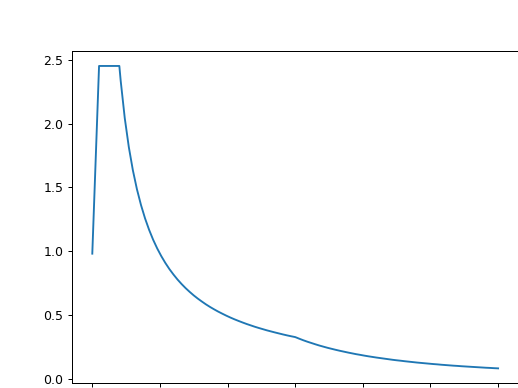

VxCQC 0.14312020822406918


TEST 01:
Run a Response Spectrum Analysis mode-by-mode.
Grab results during the loop.
Do CQC combination in post processing.

    Mode            Vx            Vy            Mx            My
0    1.0 -5.093164e-02  6.590552e-02 -5.350101e+01 -4.134546e+01
1    2.0 -8.528172e-02 -6.590552e-02  5.350101e+01 -6.923028e+01
2    3.0 -2.729634e-02 -2.015465e-02  5.514449e+00 -7.468465e+00
3    4.0 -1.488148e-02  2.015465e-02 -5.514449e+00 -4.071673e+00
4    5.0  7.347932e-33 -1.697665e-32  3.672210e-31 -1.933139e-31
5    6.0 -4.142715e-03  5.268586e-03 -7.803857e-01 -6.136211e-01
6    7.0 -6.700437e-03 -5.268586e-03  7.803857e-01 -9.924721e-01
7    8.0 -1.470176e-03  2.095553e-03 -2.041112e-01 -1.431982e-01
8    9.0 -2.986949e-03 -2.095553e-03  2.041112e-01 -2.909351e-01
9   10.0 -5.957404e-31  6.291422e-31 -3.669029e-29 -3.137697e-29
10  11.0 -1.092100e-03  1.320040e-03 -9.853827e-02 -8.152306e-02
11  12.0 -1.595554e-03 -1.320040e-03  9.853827e-02 -1.191048e-01
1

In [65]:
# following example on http://opensees.berkeley.edu/wiki/index.php/Elastic_Frame_Example
# running dynamic ground motion

%matplotlib notebook

# import OpenSees and libraries
from openseespy.opensees import *
from openseespy.postprocessing.Get_Rendering import *

# numerical and plotting tools
import numpy as np
import matplotlib.pyplot as plt
import math
from math import sqrt
import pandas as pd

# system commands
import os, os.path
import glob
import shutil

# -------------------------------
#       Generate Model
# -------------------------------

# remove existing model
wipe()

# remove existing results
# explanation here: https://stackoverflow.com/a/31989328
def remove_thing(path):
    if os.path.isdir(path):
        shutil.rmtree(path)
    else:
        os.remove(path)

def empty_directory(path):
    for i in glob.glob(os.path.join(path, '*')):
        remove_thing(i)

empty_directory('modes')
empty_directory('output')

# ---------------------------------------
#   Generate model and static analysis
# ---------------------------------------

# set modelbuilder
model('basic', '-ndm', 3, '-ndf', 6)

# units: in, kip, s
# dimensions
ft = 12.0
inch = 1.0
g = 386.1 #in/s^2
kip = 1.0
ksi = kip/(inch**2)

# material properties
Es = 29000*ksi
Gs = 11500*ksi

# -------------------------------
#       Create Nodes
# -------------------------------
# command: node(nodeID, x-coord, y-coord, z-coord)
# command: node(nodeTag, *crds, '-ndf', ndf, '-mass', *mass, '-disp', *disp, '-vel', *vel, '-accel', *accel)
# Note: Ian Prowell Dissertation: Split into 30 beam-column elements

# specify number of elements of each portion of the tower
eldiv = 6

# Defining the first node
nodeTag = 1
node(nodeTag, 0.0, 0.0, 0.0)

# Heights of tower sections
hbot = 238.2*inch
hbottap = 74.8*inch
hmid = 237.2*inch
hmidtap = 74.8*inch
htop = 238*inch

# Lower tower section (Split into eldiv elements)
for j in range(eldiv):
    nodeTag += 1
    h = (hbot/eldiv)*(j + 1)
    node(nodeTag, 0.0, 0.0, h)
    
# Tapered lower section (Split into eldiv elements)
for j in range(eldiv):
    nodeTag += 1
    h = hbot + (hbottap/eldiv)*(j + 1)
    node(nodeTag, 0.0, 0.0, h)

# Middle tower section (Split into eldiv elements)
for j in range(eldiv):
    nodeTag += 1
    h = hbot + hbottap + (hmid/eldiv)*(j + 1)
    node(nodeTag, 0.0, 0.0, h)

# Tapered middle section (Split into eldiv elements)
for j in range(eldiv):
    nodeTag += 1
    h = hbot + hbottap + hmid + (hmidtap/eldiv)*(j + 1)
    node(nodeTag, 0.0, 0.0, h)
    
# Top tower section (Split into eldiv elements)
for j in range(eldiv):
    nodeTag += 1
    h = hbot + hbottap + hmid + hmidtap + (htop/eldiv)*(j + 1)
    node(nodeTag, 0.0, 0.0, h)
    
print(nodeTag)
# restraints
# command: fix(nodeID, DOF1, DOF2, DOF3, DOF4, DOF5, DOF6) 0 = free, 1 = fixed
# Use a fixed connection for now
fix(1, 1, 1, 1, 1, 1, 1)

# geometric transformation for beam-columns
# command: geomTransf('Type', TransfTag)
# see https://opensees.berkeley.edu/wiki/index.php/Linear_Transformation 
geomTransf('PDelta', 1, 0, 1, 0) #columns

# -------------------------------
#       Define Elements
# -------------------------------

# initialize lists
D = [] # diameters in
A = [] # areas in^2
I = [] # area moment of inertia in^4
J = [] # polar moment of inertia in^4
dM = [] # distributed masses kip*s^2/in
V = [] # volumes in^3
H = [] # height of each element in
t = 0.21*inch # thickness is constant


# Determining the diameters, areas, area moment of inertias, and polar moments of each discretized tower segment
# diameters of tower
dbot = 78.7*inch
dmid = 62.9*inch
dtop = 47.2*inch

index = 0

# Lower tower section (Split into eldiv elemenets)
for j in range(eldiv):
    H.append(hbot/eldiv)
    D.append(dbot)
    A.append(((D[index])**2 - (D[index] - (2*t))**2)*math.pi/4)
    I.append(((D[index])**4 - (D[index] - 2*t)**4)*math.pi/64)
    J.append(((D[index])**4 - (D[index] - 2*t)**4)*math.pi/32)
    index += 1

# Tapered lower section (Split into eldiv elements)
for j in range(eldiv):
    H.append(hbottap/eldiv)
    d = ((j + 1)/(2*eldiv))*(dmid-dbot) + dbot # interpolating for the diameter based on eldiv
    D.append(d)
    A.append(((D[index])**2 - (D[index] - 2*t)**2)*math.pi/4)
    I.append(((D[index])**4 - (D[index] - 2*t)**4)*math.pi/64)
    J.append(((D[index])**4 - (D[index] - 2*t)**4)*math.pi/32)
    index += 1

# Middle tower section (Split into eldiv elements)
for j in range(eldiv):
    H.append(hmid/eldiv)
    D.append(dmid)
    A.append(((D[index])**2 - (D[index] - 2*t)**2)*math.pi/4)
    I.append(((D[index])**4 - (D[index] - 2*t)**4)*math.pi/64)
    J.append(((D[index])**4 - (D[index] - 2*t)**4)*math.pi/32)
    index += 1

# Tapered middle section (Split into eldiv elements)
for j in range(eldiv):
    H.append(hmidtap/eldiv)
    d = ((j + 1)/(2*eldiv))*(dtop-dmid) + dmid # interpolating for the diameter based on eldiv
    D.append(d)
    A.append(((D[index])**2 - (D[index] - 2*t)**2)*math.pi/4)
    I.append(((D[index])**4 - (D[index] - 2*t)**4)*math.pi/64)
    J.append(((D[index])**4 - (D[index] - 2*t)**4)*math.pi/32)
    index += 1
    
# Top tower section
for j in range(eldiv):
    H.append(htop/eldiv)
    D.append(dtop)
    A.append(((D[index])**2 - (D[index] - 2*t)**2)*math.pi/4)
    I.append(((D[index])**4 - (D[index] - 2*t)**4)*math.pi/64)
    J.append(((D[index])**4 - (D[index] - 2*t)**4)*math.pi/32)
    index += 1
    
# Determining volumes of tower segments
index = 0

# Lower tower section (Split into eldiv elemenets)
for j in range(eldiv):
    v = math.pi*(hbot/eldiv)*(D[index]**2 - (D[index]-2*t)**2)/4
    V.append(v)
    index += 1
    
# Tapered lower section (Split into eldiv elements)
for j in range(eldiv):
    dlower = ((dmid-dbot)*j)/(eldiv) + dbot
    dhigher = ((dmid-dbot)*(j+1))/(eldiv) + dbot
    v = math.pi*(hbottap/eldiv)*((dlower**2 +dlower*dhigher + dhigher**2)-((dlower-2*t)**2 + (dlower-2*t)*(dhigher-2*t) + (dhigher-2*t)**2))/12
    V.append(v)
    index += 1    

# Middle tower section (Split into eldiv elements)
for j in range(eldiv):
    v = math.pi*(hmid/eldiv)*(D[index]**2 - (D[index]-2*t)**2)/4
    V.append(v)
    index += 1
    
# Tapered middle section (Split into eldiv elements)
for j in range(eldiv):
    dlower = ((dtop-dmid)*j)/(eldiv) + dmid
    dhigher = ((dtop-dmid)*(j+1))/(eldiv) + dmid
    v = math.pi*(hmidtap/eldiv)*((dlower**2 +dlower*dhigher + dhigher**2)-((dlower-2*t)**2 +(dlower-2*t)*(dhigher-2*t) + (dhigher-2*t)**2))/12
    V.append(v)
    index += 1    

# Top tower section (Split into eldiv elements)
for j in range(eldiv):
    v = math.pi*(htop/eldiv)*(D[index]**2 - (D[index]-2*t)**2)/4
    V.append(v)
    index += 1


mtotal = 14.101*kip/g
vtotal = sum(V)
htotal = hbot + hbottap + hmid + hmidtap + htop

# Determining distributed masses of tower segments
# Entire tower section (Split into 5*eldiv elemenets)
for j in range(len(H)):
    distm = (mtotal*V[j])/(vtotal*H[j]) # mass/height constant
    dM.append(distm)
    
# Defining the elements and determining areas, area moment of inertias, and polar inertias for each section
# Cylindrical sections => Ix = Iy 
# Cylindrical sections => J = Iz = 2*Ix = (D^4-(D-t)^4)*(pi/32) 

# Assigning element properties
# create elastic beam-column elements - 
# command: element('elasticBeamColumn', eleTag, *eleNodes, Area, E_mod, G_mod, Jxx, Iy, Iz, transfTag, <'-mass', mass>, <'-cMass'>)
# define the columns  
for j in range(len(H)):
    element('elasticBeamColumn', j+1, j+1, j+2, A[j], Es, Gs, J[j], I[j], I[j], 1, '-mass', dM[j])

# Uncomment to see how the turbine twists
#node(nodeTag +1, 0.0, 10.0*ft, h)
#geomTransf('Linear', 2, 0, 0, 1) #columns
#element('elasticBeamColumn', len(H) + 1, len(H) + 1, len(H) + 2, A[len(H)-2], Es, Gs, J[len(H)-2], I[len(H)-2], I[len(H)-2], 2, '-mass', dM[len(H)-2])
    
# assign additional masses
# masses only act at nodes that have DoF
# command: mass(nodeID, dx, dy, dz, r@x, r@y, r@z)
# rotational inertia for a point mass: I = mr^2
whub = 9.4*kip
mhub = whub/g #kip*s^2/in
### to-do: the box is slightly higher than the last node of the tower, should we add another node? how would it be connected to the rest of the tower?
hhub = 888*inch # height of hub
node(len(H) + 2, 0.0, 0.0, hhub)
rigidLink('beam', len(H)+1, len(H)+2)
mass(len(H) + 2, mhub, mhub, mhub, 0.0, 0.0, 0.0)

# --------------------------------
#       Perform eigen analysis
# --------------------------------

numEigen = 30
lameigenValues = eigen(numEigen)

wn = [i ** 0.5 for i in lameigenValues]
fn = [i / (2*math.pi) for i in wn]

print("Natural Frequencies:", fn, "Hz")

# compute the modal properties
modalProperties("-print", "-file", "ModalReport.txt", "-unorm")

# -------------------------------------------
#       Plotting Structure and Modeshapes
# -------------------------------------------

# Display the active model with node and element tags
#plot_model("nodes","elements")

#plot_modeshape(1, 50)
#plot_modeshape(3, 50)
#plot_modeshape(6, 50)

# ----------------------------------
#       Define Response Spectrum
# ----------------------------------

# the response spectrum function
timeSeries(
	"Path",1,"-time",
	0.0,0.06,0.1,0.12,0.18,0.24,0.3,0.36,0.4,0.42,
	0.48,0.54,0.6,0.66,0.72,0.78,0.84,0.9,0.96,1.02,
	1.08,1.14,1.2,1.26,1.32,1.38,1.44,1.5,1.56,1.62,
	1.68,1.74,1.8,1.86,1.92,1.98,2.04,2.1,2.16,2.22,
	2.28,2.34,2.4,2.46,2.52,2.58,2.64,2.7,2.76,2.82,
	2.88,2.94,3.0,3.06,3.12,3.18,3.24,3.3,3.36,3.42,
	3.48,3.54,3.6,3.66,3.72,3.78,3.84,3.9,3.96,4.02,
	4.08,4.14,4.2,4.26,4.32,4.38,4.44,4.5,4.56,4.62,
	4.68,4.74,4.8,4.86,4.92,4.98,5.04,5.1,5.16,5.22,
	5.28,5.34,5.4,5.46,5.52,5.58,5.64,5.7,5.76,5.82,
	5.88,5.94,6.0,
	"-values",
	0.2,0.38,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.4762,
	0.4167,0.3704,0.3333,0.303,0.2778,0.2564,0.2381,0.2222,0.2083,0.1961,
	0.1852,0.1754,0.1667,0.1587,0.1515,0.1449,0.1389,0.1333,0.1282,0.1235,
	0.119,0.1149,0.1111,0.1075,0.1042,0.101,0.098,0.0952,0.0926,0.0901,
	0.0877,0.0855,0.0833,0.0813,0.0794,0.0775,0.0758,0.0741,0.0725,0.0709,
	0.0694,0.068,0.0667,0.0641,0.0616,0.0593,0.0572,0.0551,0.0531,0.0513,
	0.0495,0.0479,0.0463,0.0448,0.0434,0.042,0.0407,0.0394,0.0383,0.0371,
	0.036,0.035,0.034,0.0331,0.0322,0.0313,0.0304,0.0296,0.0289,0.0281,
	0.0274,0.0267,0.026,0.0254,0.0248,0.0242,0.0236,0.0231,0.0225,0.022,
	0.0215,0.021,0.0206,0.0201,0.0197,0.0193,0.0189,0.0185,0.0181,0.0177,
	0.0174,0.017,0.0167,
	"-factor",9.806)

# Plotting design spectrum

time = [0.0,0.06,0.1,0.12,0.18,0.24,0.3,0.36,0.4,0.42,
	0.48,0.54,0.6,0.66,0.72,0.78,0.84,0.9,0.96,1.02,
	1.08,1.14,1.2,1.26,1.32,1.38,1.44,1.5,1.56,1.62,
	1.68,1.74,1.8,1.86,1.92,1.98,2.04,2.1,2.16,2.22,
	2.28,2.34,2.4,2.46,2.52,2.58,2.64,2.7,2.76,2.82,
	2.88,2.94,3.0,3.06,3.12,3.18,3.24,3.3,3.36,3.42,
	3.48,3.54,3.6,3.66,3.72,3.78,3.84,3.9,3.96,4.02,
	4.08,4.14,4.2,4.26,4.32,4.38,4.44,4.5,4.56,4.62,
	4.68,4.74,4.8,4.86,4.92,4.98,5.04,5.1,5.16,5.22,
	5.28,5.34,5.4,5.46,5.52,5.58,5.64,5.7,5.76,5.82,
	5.88,5.94,6.0]

NormA = [0.2,0.38,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.4762,
	0.4167,0.3704,0.3333,0.303,0.2778,0.2564,0.2381,0.2222,0.2083,0.1961,
	0.1852,0.1754,0.1667,0.1587,0.1515,0.1449,0.1389,0.1333,0.1282,0.1235,
	0.119,0.1149,0.1111,0.1075,0.1042,0.101,0.098,0.0952,0.0926,0.0901,
	0.0877,0.0855,0.0833,0.0813,0.0794,0.0775,0.0758,0.0741,0.0725,0.0709,
	0.0694,0.068,0.0667,0.0641,0.0616,0.0593,0.0572,0.0551,0.0531,0.0513,
	0.0495,0.0479,0.0463,0.0448,0.0434,0.042,0.0407,0.0394,0.0383,0.0371,
	0.036,0.035,0.034,0.0331,0.0322,0.0313,0.0304,0.0296,0.0289,0.0281,
	0.0274,0.0267,0.026,0.0254,0.0248,0.0242,0.0236,0.0231,0.0225,0.022,
	0.0215,0.021,0.0206,0.0201,0.0197,0.0193,0.0189,0.0185,0.0181,0.0177,
	0.0174,0.017,0.0167]

NormA = [i * 4.903 for i in NormA]

plt.plot(time, NormA)


# -------------------------------------------
#       Determining Responses using CQC
# -------------------------------------------

# currently we use same damping for each mode
dmp = [0.005]*len(lameigenValues)

# we don't want to scale some modes...
scalf = [1.0]*len(lameigenValues)

# Defining a CQC function
def CQC(mu, lambdas, dmp, scalf):
	u = 0.0
	ne = len(lambdas)
	for i in range(ne):
		for j in range(ne):
			di = dmp[i]
			dj = dmp[j]
			bij = lambdas[i]/lambdas[j]
			rho = ((8.0*sqrt(di*dj)*(di+bij*dj)*(bij**(3.0/2.0))) /
				((1.0-bij**2.0)**2.0 + 4.0*di*dj*bij*(1.0+bij**2.0) + 
				4.0*(di**2.0 + dj**2.0)*bij**2.0))
			u += scalf[i]*mu[i] * scalf[j]*mu[j] * rho;
	return sqrt(u)

# Running a response spectrum analysis mode-by mod, using a loop
Vx = [] # Base shear in the x direction
Mx = [] # Overturning moment in the x direction
Vy = [] # Base shear in the y direction
My = [] # Overturning moment in the y direction

# Some settings for the response spectrum analysis
tsTag = 1 # use the timeSeries 1 as response spectrum function
direction = 1 # excited DOF = Ux SHOULD THIS BE ONLY IN THE Ux DIRECTION?

for i in range(len(lameigenValues)):
    responseSpectrum(tsTag, direction, '-mode', i+1)
    forceVx = eleForce(1, 1) # Vx
    forceVy = eleForce(1, 2) # Vy
    forceMx = eleForce(1, 4) # Mx
    forceMy = eleForce(1, 5) # My
    Vx.append(forceVx)
    Vy.append(forceVy)
    Mx.append(forceMx)
    My.append(forceMy)

# Post-process the results using the CQC modal combination for the Vx, Vy, Mx, My response
VxCQC = CQC(Vx, lameigenValues, dmp, scalf)
VyCQC = CQC(Vy, lameigenValues, dmp, scalf)
MxCQC = CQC(Mx, lameigenValues, dmp, scalf)
MyCQC = CQC(My, lameigenValues, dmp, scalf)
print('VxCQC', VxCQC)

# Display information
Vxtable = Vx.append(VxCQC)
Vytable = Vy.append(VyCQC)
Mxtable = Mx.append(MxCQC)
Mytable = My.append(MyCQC)
Modes = range(1, len(lameigenValues)+2)

print('\n\nTEST 01:\nRun a Response Spectrum Analysis mode-by-mode.\nGrab results during the loop.\nDo CQC combination in post processing.\n')
Responses = [Modes, Vx, Vy, Mx, My]
headers = ['Mode', 'Vx', 'Vy', 'Mx', 'My']
print(pd.DataFrame(Responses, headers).T)

CQCResponses = ['CQC', VxCQC, VyCQC, MxCQC, MyCQC]
CQCheaders = ['CQC Response', 'Vx', 'Vy', 'Mx', 'My']
print(pd.DataFrame(CQCResponses, CQCheaders).T)
    
# Defining a recorder to determine the 
#filenameMbox = 'Mbo_x.txt' # Overturning moment in the x direction
#recorder('Element', '-file', filenameMbox, '-closeOnWrite', '-precision', 16, '-ele', 1, 'section', '1', 'force')
